In [1]:
import pennylane as qml
import matplotlib.pyplot as plt
from pennylane import numpy as np

In [2]:
np.random.seed(42)

def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2
    loss = loss / len(labels)
    return loss

Let's define the target function, which will be $f(x) = 0.1 + (0.15 + 0.15j)e^{-2xj} + (0.15 + 0.15j)e^{2xj}$.

In [49]:
degree = 4
coeffs = [0.15 + 0.15j] * degree
coeff0 = 0.1
scaling_target = [1,1,1,5/4]

def target_function(x):
    res = coeff0
    for idx, coeff in enumerate(coeffs):
        exponent = np.complex128(scaling_target[idx]*(idx+1)*x*1j)
        conj_coeff = np.conjugate(coeff)
        res += coeff * np.exp(exponent) + conj_coeff * np.exp(-exponent)
    return np.real(res)

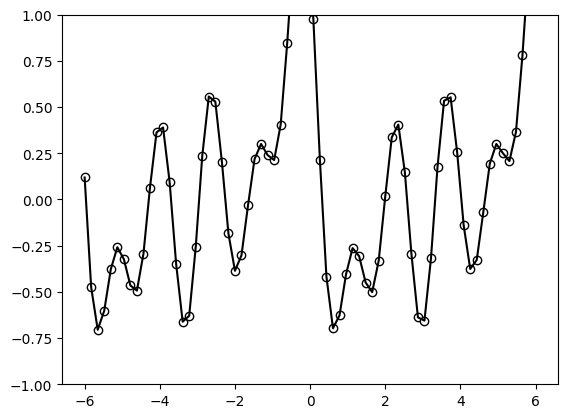

In [50]:
x = np.linspace(-6, 6, 70, requires_grad=False)
target_y = np.array([target_function(x_) for x_ in x], requires_grad=False)

plt.plot(x, target_y, c='black')
plt.scatter(x, target_y, facecolor='white', edgecolor='black')
plt.ylim(-1, 1)
plt.show()

Now, let's define the quantum model.

In [51]:
scaling_model = [2,3]

dev = qml.device('default.qubit', wires=1)

def S(x):
    """Data-encoding circuit block."""
    qml.RX(x, wires=0)

def W(theta):
    """Trainable circuit block."""
    qml.Rot(theta[0], theta[1], theta[2], wires=0)


@qml.qnode(dev, interface="autograd")
def serial_quantum_model(weights, x):

    for theta in weights[:-1]:
        W(theta)
        S(scaling_model[0]*x)
        W(theta)
        S(scaling_model[1]*x)

    # (L+1)'th unitary
    W(weights[-1])

    return qml.expval(qml.PauliZ(wires=0))

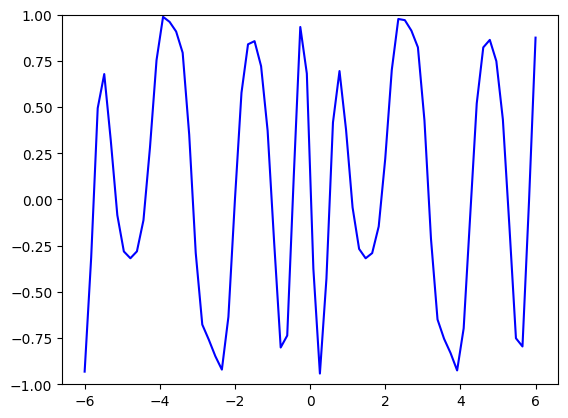

In [52]:
r = 2 # number of times the encoding gets repeated (here equal to the number of layers)
weights = 2 * np.pi * np.random.random(size=(r+1, 3), requires_grad=True) # some random initial weights

x = np.linspace(-6, 6, 70, requires_grad=False)
random_quantum_model_y = [serial_quantum_model(weights, x_) for x_ in x]

plt.plot(x, random_quantum_model_y, c='blue')
plt.ylim(-1,1)
plt.show()

Now, let's fit the model to the target.

In [53]:
def cost(weights, x, y):
    predictions = [serial_quantum_model(weights, x_) for x_ in x]
    return square_loss(y, predictions)

max_steps = 50
opt = qml.AdamOptimizer(0.3)
batch_size = 25
cst = [cost(weights, x, target_y)]  # initial cost

for step in range(max_steps):

    # Select batch of data
    batch_index = np.random.randint(0, len(x), (batch_size,))
    x_batch = x[batch_index]
    y_batch = target_y[batch_index]

    # Update the weights by one optimizer step
    weights, _, _ = opt.step(cost, weights, x_batch, y_batch)

    # Save, and possibly print, the current cost
    c = cost(weights, x, target_y)
    cst.append(c)
    if (step + 1) % 10 == 0:
        print("Cost at step {0:3}: {1}".format(step + 1, c))

Cost at step  10: 0.40104414915762465
Cost at step  20: 0.2356936240322894
Cost at step  30: 0.223702442571456
Cost at step  40: 0.20106423818341035
Cost at step  50: 0.18741199699230132


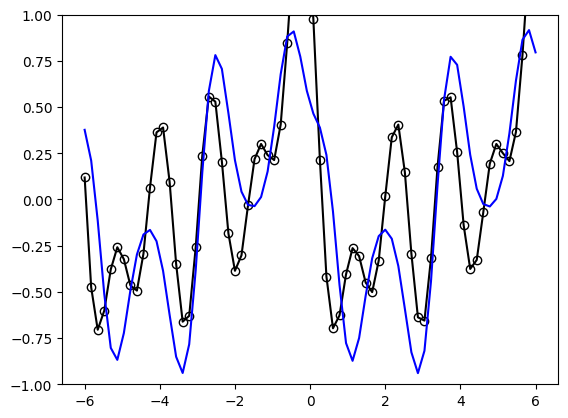

In [55]:
predictions = [serial_quantum_model(weights, x_) for x_ in x]

plt.plot(x, target_y, c='black')
plt.scatter(x, target_y, facecolor='white', edgecolor='black')
plt.plot(x, predictions, c='blue')
plt.ylim(-1,1)
plt.show()

# Multivariate Fourier Series

In [3]:
#Let's define a target function, which is a two-dimensional Fourier series of degree 1:

# Define the Fourier series coefficients
a0 = 0.10
a1 = 0.15 + 0.15j
b1 = 0.15 + 0.15j

def target_function(x,y):
    return np.real(a0/2 + a1*np.cos(x) + b1*np.sin(y))


In [8]:
# Define the range of x and y values
x = np.linspace(-6, 6, 25, requires_grad=False)
y = np.linspace(-6, 6, 25, requires_grad=False)
target_z = np.reshape(np.array([[target_function(x_, y_) for x_ in x] for y_ in y], requires_grad=False), newshape = (1,))

# Create a meshgrid of x and y values
X, Y = np.meshgrid(x, y)

# Plot the Fourier series
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, target_z)
plt.show()

ValueError: cannot reshape array of size 625 into shape (1,)

In [5]:
scaling_model = [1]

dev = qml.device('default.qubit', wires=2)

def S(x,y):
    """Data-encoding circuit block."""
    qml.RX(x, wires=0)
    qml.RY(y, wires=0)

def W(theta):
    """Trainable circuit block."""
    qml.Rot(theta[0], theta[1], theta[2], wires=0)
    qml.Rot(theta[3], theta[4], theta[5], wires=0)

def entangling():
    qml.CZ(wires=[0,1])


@qml.qnode(dev, interface="autograd")
def serial_quantum_model(weights, x,y):

    for theta in weights[:-1]:
        W(theta)
        entangling()
        S(scaling_model[0]*x, scaling_model[0]*y)
        #W(theta)
        #entangling()
        #S(scaling_model[1]*x)

    # (L+1)'th unitary
    W(weights[-1])

    return qml.expval(qml.PauliZ(wires=0) @ qml.PauliZ(wires=1))

[[tensor(0.77255622, requires_grad=True), tensor(0.94123786, requires_grad=True), tensor(0.97599368, requires_grad=True), tensor(0.86831424, requires_grad=True), tensor(0.64456323, requires_grad=True), tensor(0.3595227, requires_grad=True), tensor(0.08298051, requires_grad=True), tensor(-0.11735617, requires_grad=True), tensor(-0.19243793, requires_grad=True), tensor(-0.12388214, requires_grad=True), tensor(0.07152636, requires_grad=True), tensor(0.34594475, requires_grad=True), tensor(0.63218583, requires_grad=True), tensor(0.86016781, requires_grad=True), tensor(0.97407275, requires_grad=True), tensor(0.94601274, requires_grad=True), tensor(0.78285786, requires_grad=True), tensor(0.5245541, requires_grad=True), tensor(0.23434325, requires_grad=True), tensor(-0.01672097, requires_grad=True), tensor(-0.16716928, requires_grad=True), tensor(-0.18016668, requires_grad=True), tensor(-0.05253096, requires_grad=True), tensor(0.18448821, requires_grad=True), tensor(0.47286027, requires_grad=

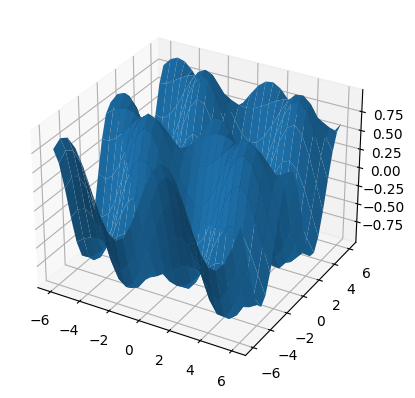

In [6]:
r = 1 # number of times the encoding gets repeated (here equal to the number of layers)
weights = 2 * np.pi * np.random.random(size=(r+1, 6), requires_grad = True) # some random initial weights

random_quantum_model_z = [[serial_quantum_model(weights, x_, y_) for x_ in x] for y_ in y]

print(random_quantum_model_z)

X, Y = np.meshgrid(x, y)

# Plot the Fourier series
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, np.array(random_quantum_model_z))
plt.show()

In [135]:
def cost(weights, x, y, z):
    predictions = [[serial_quantum_model(weights, x_,y_) for x_ in x] for y_ in y]
    return square_loss(z, predictions)

max_steps = 50
opt = qml.AdamOptimizer(0.3)
batch_size = 25
cst = [cost(weights, x, y,target_z)]  # initial cost
print(cst)

for step in range(max_steps):

    # Select batch of data
    batch_index = np.random.randint(0, len(x), (batch_size,))
    x_batch = x[batch_index]
    y_batch = y[batch_index]
    z_batch = target_z[batch_index]

    # Update the weights by one optimizer step
    weights, _, _ = opt.step(cost, weights, x_batch, y_batch, z_batch)

    # Save, and possibly print, the current cost
    c = cost(weights, x, y, target_z)
    cst.append(c)
    if (step + 1) % 10 == 0:
        print("Cost at step {0:3}: {1}".format(step + 1, c))

[tensor([0.56636564, 0.32271022, 0.0998427 , 0.06349726, 0.20268419,
        0.35066581, 0.34774654, 0.19388465, 0.04939798, 0.08295136,
        0.3077159 , 0.55848188, 0.63340643, 0.47255764, 0.21082361,
        0.0570787 , 0.10992202, 0.27749336, 0.37252459, 0.29264256,
        0.11816349, 0.03656784, 0.16350515, 0.4265185 , 0.62082748], requires_grad=False)]


KeyboardInterrupt: 